In [7]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
try:
    import seaborn as sns
except ImportError:
    print('Seaborn not found')
%matplotlib inline
from IPython.display import display


from tyssue import Sheet, SheetGeometry as geom
from tyssue import config

from tyssue.dynamics import SheetModel as basemodel

from tyssue.dynamics.apoptosis_model import SheetApoptosisModel as model
from tyssue.solvers.sheet_vertex_solver import Solver as solver
#from tyssue.dynamics.sheet_isotropic_model import isotropic_relax

from tyssue.draw import sheet_view
#from tyssue.draw.threejs_draw import view_3js

from tyssue.io.hdf5 import load_datasets
#from tyssue.core.objects import get_opposite


Seaborn not found


In [63]:
import os
home = os.getcwd()
sim_save_dir = '../data/png/apoptosis/'
if not os.path.isdir(sim_save_dir):
    os.mkdir(sim_save_dir)

In [40]:
min_settings = {
        'options': {
            'disp': False,
            'ftol': 1e-8,
            'gtol': 1e-8},
        }


def load_before_apopto(anchor_tension=0, fixed_boundaries=True):

    h5store = '../data/hf5/before_apoptosis.hf5'
    #h5store = '../data/hf5/small_hexagonal.hf5'

    datasets = load_datasets(h5store,
                             data_names=['face', 'vert', 'edge'])
    specs = config.geometry.cylindrical_sheet()
    sheet = Sheet('fold', datasets, specs)
    sheet.sanitize()
    geom.update_all(sheet)

    sheet.edge_df['opposite'] = sheet.get_opposite()

    sheet.vert_df.is_active = 1
    if anchor_tension > 0:
        create_anchors(sheet)
        nondim_specs = config.dynamics.quasistatic_sheet_spec_anchors()
        nondim_specs['edge']['anchor_tension'] = anchor_tension
    else:
        nondim_specs = config.dynamics.quasistatic_sheet_spec()
        if fixed_boundaries:
            free_edges = sheet.edge_df[sheet.edge_df.opposite==-1].index
            free_srces = set(sheet.edge_df.loc[free_edges, 'srce'])
            sheet.vert_df.loc[free_srces, 'is_active'] = 0
            sheet.edge_df.loc[free_edges, 'is_active'] = 0
            free_faces = set(sheet.edge_df.loc[free_edges, 'face'])
            sheet.face_df.loc[free_faces, 'is_alive'] = 0

    dim_model_specs = model.dimensionalize(nondim_specs)
    sheet.update_specs(dim_model_specs, reset=True)
    # isotropic_relax(sheet, nondim_specs)
    # sheet.vert_df.loc[dead_src, 'is_active'] = 0
    return sheet, nondim_specs

sheet, nondim_specs = load_before_apopto(0, fixed_boundaries=True)

geom.update_all(sheet)

Reseting column contractility of the face dataset with new specs
Reseting column vol_elasticity of the face dataset with new specs
Reseting column prefered_height of the face dataset with new specs
Reseting column prefered_area of the face dataset with new specs
Reseting column prefered_vol of the face dataset with new specs
Reseting column radial_tension of the vert dataset with new specs
Reseting column is_active of the vert dataset with new specs
Reseting column line_tension of the edge dataset with new specs
Reseting column is_active of the edge dataset with new specs


In [41]:
import ipyvolume as ipv
ipv.clear()
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'])
fig

/home/guillaume/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

/home/guillaume/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


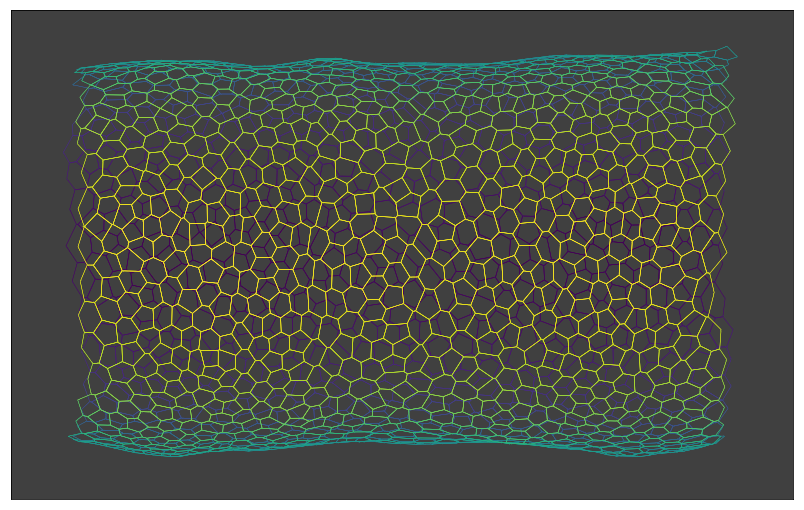

In [42]:
def leg_joint_view(sheet, coords=['z', 'x', 'y']):

    x, y, z = coords
    datasets = {}
    
    datasets['face'] = sheet.face_df.sort_values(z)
    datasets['vert'] = sheet.vert_df.sort_values(z)
    edge_z = 0.5 * (sheet.upcast_srce(sheet.vert_df[z]) +
                    sheet.upcast_trgt(sheet.vert_df[z]))
    datasets['edge'] = sheet.edge_df.copy()
    datasets['edge'][z] = edge_z
    datasets['edge'] = datasets['edge'].sort_values(z)
    
    tmp_sheet = Sheet('tmp', datasets,
                      sheet.specs)
    tmp_sheet.reset_index()
    cmap = plt.cm.get_cmap('viridis')
    
    e_depth = (tmp_sheet.edge_df[z] -
               tmp_sheet.edge_df[z].min()) / tmp_sheet.edge_df[z].ptp()
    depth_cmap = cmap(e_depth)
    draw_specs = {
        'vert': {
            'visible': False
            },
        'edge': {
            'color': depth_cmap,
            #'zorder': depth.values
            }
        }
    
    fig, ax = sheet_view(tmp_sheet, coords[:2], **draw_specs)
    ax.set_xlim(-80, 80)
    ax.set_ylim(-50, 50)
    ax.set_facecolor('#404040')
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_frame_on(False)
    fig.set_size_inches((16, 9))
    fig.set_frameon(False)
    fig.set_clip_box(ax.bbox)
    return fig, ax

fig, ax = leg_joint_view(sheet)
plt.savefig('../data/png/before_apoptosis.png', bbox_inches='tight')

In [43]:
res = solver.find_energy_min(sheet, geom, model, **min_settings)
print(res['success'])

True


number of apoptotic cells: 20


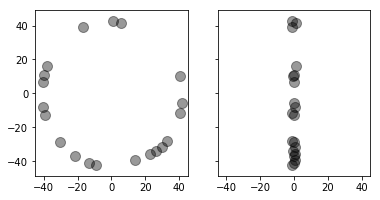

In [45]:
def apopto_pdf(zed, theta, z0=0.,
               width_apopto=1.1, amp=0.7):
    p = (np.exp(-(zed - z0)**2 / width_apopto**2) *
         (1 - amp*(np.cos(theta/2)**2)))
    return p

def get_apopto_cells(sheet):

    np.random.seed(40)
    sheet.face_df['theta'] = np.arctan2(sheet.face_df['x'],
                                        sheet.face_df['y'])
    
    p_apopto = apopto_pdf(sheet.face_df['z'], sheet.face_df['theta'])
    rand_field = np.random.random(sheet.face_df.shape[0])
    apopto_cells = p_apopto[p_apopto>rand_field].index
    apopto_cells = np.array([c for c in sheet.face_df.loc[apopto_cells].sort_values('x').index
                             if sheet.face_df.loc[c, 'is_alive']])
    return apopto_cells

apopto_cells = get_apopto_cells(sheet)
print('number of apoptotic cells: {}'.format(apopto_cells.size))

fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True, sharey=True)
ax0.scatter(sheet.face_df.loc[apopto_cells, 'x'], 
            sheet.face_df.loc[apopto_cells, 'y'], c='k',
            s=100, alpha=0.4)
ax0.set_aspect('equal')


ax1.scatter(sheet.face_df.loc[apopto_cells, 'z'], 
            sheet.face_df.loc[apopto_cells, 'y'], c='k',
            s=100, alpha=0.4)
ax1.set_aspect('equal')
ax1.set_xlim(-45, 45);

In [46]:
apopto_cells

array([ 416,  470, 1491, 1653,  389, 1629, 1378,  281, 1371, 1607,  986,
        200,  918,  940,  740, 1464, 1027, 1197, 1537,  848])

/home/guillaume/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


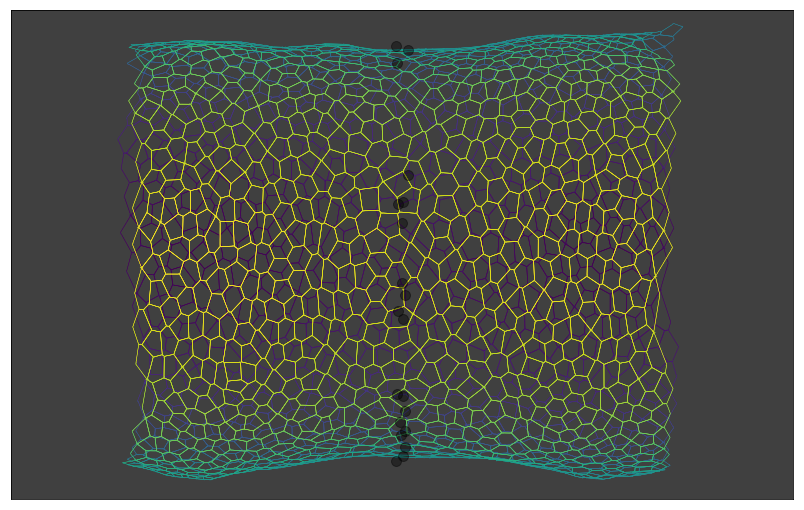

In [51]:
fig, ax = leg_joint_view(sheet)

ax.scatter(sheet.face_df.loc[apopto_cells, 'z'], 
           sheet.face_df.loc[apopto_cells, 'y'], c='k',
           s=100, alpha=0.4)

plt.savefig('before.png', bbox_inches='tight')

In [64]:
def apoptosis_time_table(sheet,
                         apoptotic_cell,
                         events,
                         start_t=0):

    settings = sheet.settings['apoptosis']
    shrink_steps = settings['shrink_steps']
    rad_tension = settings['rad_tension']
    contractile_increase = settings['contractile_increase']
    contract_span = settings['contract_span']

    apoptotic_edges = sheet.edge_df[sheet.edge_df['face'] == apoptotic_cell]

    n_sides = apoptotic_edges.shape[0]
    # Number of type 1 transitions to solve the rosette
    n_type1 = n_sides - 3
    end_shrink = start_t + shrink_steps
    end_t = start_t + shrink_steps + n_type1

    times = range(start_t, end_t+1)
    shrink_times = range(start_t, end_shrink)

    cell_time_idx = pd.MultiIndex.from_tuples(
        [(t, apoptotic_cell) for t in times],
        names=['t', 'face'])

    time_table = pd.DataFrame(index=cell_time_idx,
                              columns=events.keys())

    pref_vols = np.logspace(0., -4., shrink_steps)
    time_table.loc[start_t: end_shrink-1, 'shrink'] = pref_vols

    rad_tensions = np.ones(shrink_steps) * rad_tension / shrink_steps
    time_table.loc[start_t: end_shrink-1, 'ab_pull'] = rad_tensions

    time_table.loc[end_shrink: end_t-1, 'type1_at_shorter'] = 1
    time_table.loc[end_t, 'type3'] = 1

    neighbors = sheet.get_neighborhood(apoptotic_cell, contract_span)
    nb_t_idx = pd.MultiIndex.from_product([shrink_times, neighbors['face']],
                                          names=['t', 'face'])

    contracts = (np.ones(shrink_steps).repeat(neighbors.shape[0]) *
                 contractile_increase / shrink_steps)

    contracts = contracts.reshape((shrink_steps,
                                   neighbors.shape[0]))
    contracts = contracts / np.atleast_2d(neighbors.order.values)
    time_table = pd.concat([time_table,
                            pd.DataFrame(contracts.ravel(),
                                         index=nb_t_idx,
                                         columns=['contract', ])])

    return times, time_table.sort_index()

    
class SheetEvents():

    def __init__(self, sheet, model, geom):
        self.sheet = sheet
        self.model = model
        self.geom = geom

    @property
    def events(self):
        events = {
            'shrink': self.shrink,
            'grow': self.grow,
            'contract': self.contract,
            'type1_at_shorter': self.type1_at_shorter,
            'type3': self.type3,
            'ab_pull': self.ab_pull,
            }
        return events

    def shrink(self, face, *args):

        factor = args[0]
        new_vol = self.sheet.specs['face']['prefered_vol'] * factor
        self.sheet.face_df.loc[face, 'prefered_vol'] = new_vol

    def grow(self, face, *args):
        self.shrink(face, *args)

    def contract(self, face, *args):

        factor = args[0]
        new_contractility = self.sheet.specs['face']['contractility'] * factor
        self.sheet.face_df.loc[face, 'contractility'] += new_contractility

    def type1_at_shorter(self, face, *args):

        edges = self.sheet.edge_df[self.sheet.edge_df['face'] == face]
        shorter = edges.length.argmin()
        type1_transition(self.sheet, shorter)
        self.geom.update_all(self.sheet)

    def type3(self, face, *args):

        remove_face(self.sheet, face)
        self.geom.update_all(self.sheet)

    def ab_pull(self, face, *args):

        verts = self.sheet.edge_df[
            self.sheet.edge_df['face'] == face]['srce']
        factor = args[0]
        new_tension = self.sheet.specs['edge']['line_tension'] * factor
        self.sheet.vert_df.loc[verts, 'radial_tension'] += new_tension



In [65]:

from tyssue.topology.sheet_topology import remove_face
import os

import logging
logger = logging.Logger('event_log')

def get_time_table(sheet, apopto_cells,
                   events):

    time_tables = []
    for strat_t, cell in enumerate(apopto_cells):

        times, time_table = apoptosis_time_table(sheet, cell,
                                                 events, start_t=strat_t)
        time_tables.append(time_table)
    time_table = pd.concat(time_tables).sort_index()
    times = time_table.index.levels[0]
    return times, time_table

def local_active(sheet, face):
    
    f_verts = sheet.edge_df[sheet.edge_df['face'] == face]['srce']
    sheet.vert_df.is_active = 0
    sheet.vert_df.is_active.loc[f_verts] = 1
    

def time_step(face_events, events,
              sheet, geom, model, dirname):
    buf_active = sheet.vert_df['is_active'].copy()
    for face, evts in face_events.iterrows():
        if np.isnan(face): # don't know why this happens
            continue
        for event_name, event_arg in evts.dropna().items():
            if ((not sheet.face_df.loc[face, 'is_alive']) or
                np.isnan(sheet.face_df.loc[face, 'is_alive'])):
                logger.info('skipped: face: {}, event: {}'.format(face, event_name))
                continue
            events[event_name](face, event_arg)
            try:
                #pos_idx = sheet.edge_df[sheet.edge_df['face'] == face]['srce']
                #res = solver.find_energy_min(sheet, geom, model,
                #                             pos_idx=pos_idx, **settings)
                logger.info('done: face: {}, event: {}'.format(face, event_name))
            except:
                continue
    #pos_idx = sheet.vert_df[(sheet.vert_df.z > -3)  & (sheet.vert_df.z < 3)].index

    # relax the rest
    res = solver.find_energy_min(sheet, geom, model, **min_settings)

    
def run_sim(sheet, apopto_cells,
            geom, model, dirname):
    
    times, time_table = get_time_table(sheet, apopto_cells,
                                       events)
    event_logfile = os.path.join(dirname, 'events.log')
    hdlr = logging.FileHandler(event_logfile)
    hdlr.setLevel('INFO')
    logger.addHandler(hdlr)
    
    for t in times:
        face_events = time_table.loc[t]
        time_step(face_events, events,
                  sheet, geom, model, dirname)
        fig, ax = leg_joint_view(sheet)
        if t // 10 == 0:
            # relax boundary cells
            sheet.vert_df.is_active = 1 - sheet.vert_df.is_active
            res = solver.find_energy_min(sheet, geom, model, **min_settings)
            sheet.vert_df.is_active = 1 - sheet.vert_df.is_active

        
        figname = os.path.join(
            dirname, 'fold_formation_{:03d}.png'.format(t))
        plt.savefig(figname, bbox_inches='tight')
        plt.close(fig)
        
    logger.removeHandler(hdlr)



starting ../data/png/apoptosis/1_lambda_2_gamma


/home/guillaume/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:52: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/guillaume/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


error: failed in converting 3rd argument `l' of _lbfgsb.setulb to C/Fortran array

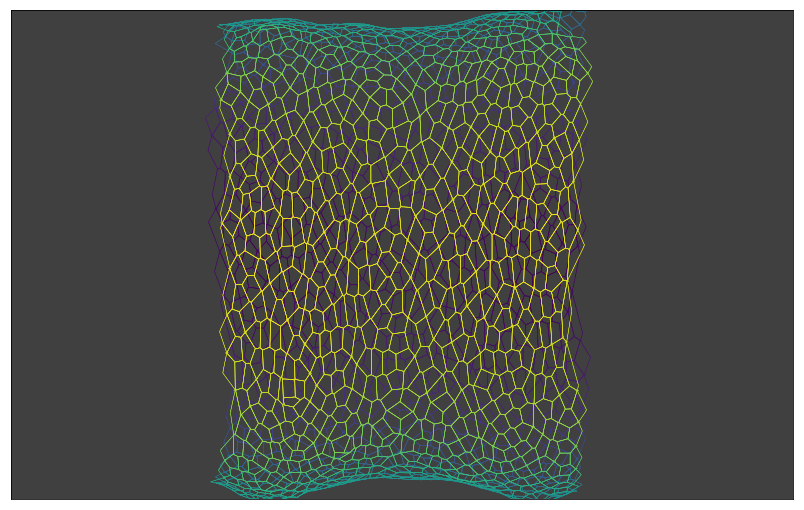

In [66]:
settings = {
    'shrink_steps': 10,
    'rad_tension': 2.0,
    'contractile_increase': 2.0,
    'contract_span': 3
    }

tensions = [1,]# 1]#, 0, 0]
contracts = [2,]# 0]#, 2, 0]
dirnames = ['{}_lambda_{}_gamma'.format(l, g)
            for l, g in zip(tensions, contracts)]
dirnames = [os.path.join(sim_save_dir, dirname)
            for dirname in dirnames]

for l, g, dirname in zip(tensions, contracts, dirnames):
    
    datasets = {key: val.copy() for key, val
                in sheet.datasets.items()}
    specs = sheet.specs
    
    sheet2 = Sheet('fold', datasets, specs) # load_before_apopto()
    events = SheetEvents(sheet2, model, geom).events
    res = solver.find_energy_min(sheet2, geom, model,
                                 **min_settings)
    print('starting {}'.format(dirname))
    try:
        os.mkdir(dirname)
    except IOError:
        pass
    settings.update(
        {'rad_tension': l,
         'contractile_increase': g})
    sheet2.settings['apoptosis'] = settings
    run_sim(sheet2, apopto_cells,
            geom, model, dirname)

    print('{} done'.format(dirname))
    print('~~~~~~~~~~~~~~~~~~~~~\n')
    

In [ ]:
times, time_table = get_time_table(sheet, apopto_cells,
                                   events)

n_events = len(time_table.columns)
fig, axes = plt.subplots(n_events, 1, sharex=True)

fig.set_size_inches(8, 3*n_events)

for f, face_data in time_table.groupby(level='face'):
    for ax, col in zip(axes, time_table.columns):
        col_data = face_data[col].dropna()
        if col_data.shape[0]:
            ax.plot(col_data.index.get_level_values(0).values,
                    col_data.values, '+-', label=str(f))

for ax, col in zip(axes, time_table.columns):
    ax.set_ylabel(col)

In [ ]:
fig, ax = leg_joint_view(sheet2)